Library Imports

In [1]:
import os
import zipfile
import random
import joblib
import cv2
import kagglehub
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


Importing the TinyDataset Folder I uploaded from my kaggle (public)

In [2]:



path = kagglehub.dataset_download("imamajawad123/tinydataset")

print("Path to dataset files:", path)

path2 = os.path.join(path, "TinyImageNet100")

files = os.listdir(path2)

print("Sample folders/files in", path2, ":", files)

100%|██████████| 98.1M/98.1M [00:06<00:00, 16.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/imamajawad123/tinydataset/versions/1
Sample folders/files in /root/.cache/kagglehub/datasets/imamajawad123/tinydataset/versions/1/TinyImageNet100 : ['n02948072', 'n02793495', 'n02165456', 'n02123045', 'n02883205', 'n02231487', 'n02106662', 'n02233338', 'n02808440', 'n01698640', 'n01983481', 'n01944390', 'n02666196', 'n02395406', 'n02074367', 'n01644900', 'n02988304', 'n01770393', 'n01945685', 'n02950826', 'n02802426', 'n02509815', 'n03160309', 'n02977058', 'n01443537', 'n01629819', 'n03126707', 'n02125311', 'n02321529', 'n02206856', 'n02814533', 'n02415577', 'n02999410', 'n01768244', 'n03100240', 'n02085620', 'n02113799', 'n02226429', 'n02486410', 'n01950731', 'n02788148', 'n02823428', 'n02837789', 'n02236044', 'n02892201', 'n01855672', 'n02963159', 'class_name.txt', 'n02795169', 'n03042490', 'n02002724', 'n01984695', 'n02769748', 'n02268443', 'n02132136', 'n02730930', 'n02917067', 'n02281406', 'n02843684', 'n02481823', 'n02423022'

In [ ]:
path2

'/root/.cache/kagglehub/datasets/imamajawad123/tinydataset/versions/1/TinyImageNet100'

##Phase 1

In [ ]:
def load_dataset(dataset_root, class_list_file, num_classes=15, train_samples=400, test_samples=100, shuffle=True):
    """ Loads dataset, selecting classes and splitting into train/test sets. """
    with open(class_list_file, 'r') as file:
        class_map = {line.split('\t')[0]: line.split('\t')[1].strip() for line in file}

    class_folders = sorted(os.listdir(dataset_root))
    selected_classes = random.sample(class_folders, num_classes) if shuffle else class_folders[:num_classes]

    train_files, test_files, train_labels, test_labels = [], [], [], []

    for idx, class_name in enumerate(selected_classes):
        img_dir = os.path.join(dataset_root, class_name, 'images')
        images = sorted(os.listdir(img_dir))[:train_samples + test_samples]

        train_files.extend([os.path.join(img_dir, img) for img in images[:train_samples]])
        test_files.extend([os.path.join(img_dir, img) for img in images[train_samples:train_samples + test_samples]])

        train_labels.extend([idx] * train_samples)
        test_labels.extend([idx] * test_samples)

    print(f"Number of selected classes: {num_classes}")
    print(f"Selected classes: {selected_classes}")
    print("Class names in the dataset:")
    for class_name in selected_classes:
        print(f"{class_name}: {class_map.get(class_name, 'Unknown')}")  # Print class name from class_map

    return train_files, test_files, train_labels, test_labels, class_map, selected_classes

# Load the dataset

root_dir = "/root/.cache/kagglehub/datasets/imamajawad123/tinydataset/versions/1/TinyImageNet100"
class_list = "/root/.cache/kagglehub/datasets/imamajawad123/tinydataset/versions/1/TinyImageNet100/class_name.txt"
train_files, test_files, train_labels, test_labels, class_map , selected_classes= load_dataset(root_dir, class_list)


Number of selected classes: 15
Selected classes: ['n02395406', 'n02823428', 'n02123045', 'n01770393', 'n02808440', 'n02815834', 'n02190166', 'n01774384', 'n02906734', 'n02486410', 'n01984695', 'n02437312', 'n02165456', 'n01698640', 'n02814860']
Class names in the dataset:
n02395406: hog, pig, grunter, squealer, Sus scrofa
n02823428: beer bottle
n02123045: tabby, tabby cat
n01770393: scorpion
n02808440: bathtub, bathing tub, bath, tub
n02815834: beaker
n02190166: fly
n01774384: black widow, Latrodectus mactans
n02906734: broom
n02486410: baboon
n01984695: spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish
n02437312: Arabian camel, dromedary, Camelus dromedarius
n02165456: ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle
n01698640: American alligator, Alligator mississipiensis
n02814860: beacon, lighthouse, beacon light, pharos


##Phase 2

Test Set Accuracy + Classification Report

In [4]:


def extract_features(image_paths, method='SIFT'):
    """ Extracts keypoints and descriptors using SIFT or ORB. """
    extractor = cv2.SIFT_create() if method == 'SIFT' else cv2.ORB_create()
    descriptors_list = []

    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        keypoints, descriptors = extractor.detectAndCompute(img, None)
        descriptors_list.append(descriptors)

    return descriptors_list

def build_bow_model(descriptors, num_clusters=100):
    """ Constructs a BoW model using K-Means clustering. """
    all_descriptors = np.vstack([desc for desc in descriptors if desc is not None])
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(all_descriptors)

    bow_features = []
    for desc in descriptors:
        hist = np.zeros(num_clusters)
        if desc is not None:
            labels = kmeans.predict(desc)
            for label in labels:
                hist[label] += 1
        bow_features.append(hist)

    return np.array(bow_features)

def fisher_vector_encoding(descriptors, num_clusters=100):
    """ Computes Fisher Vectors using a Gaussian Mixture Model. """
    all_descriptors = np.vstack([desc for desc in descriptors if desc is not None])

    gmm = GaussianMixture(n_components=num_clusters, covariance_type='diag', max_iter=300, tol=1e-3, random_state=42).fit(all_descriptors)

    fv_features = []
    for desc in descriptors:
        if desc is None:
            fv_features.append(np.zeros(2 * num_clusters))
            continue

        probabilities = gmm.predict_proba(desc)
        fisher_vector = np.sum(probabilities, axis=0)

        # Padding if the fisher_vector length is shorter than expected
        if len(fisher_vector) < 2 * num_clusters:
            padding = np.zeros(2 * num_clusters - len(fisher_vector))
            fisher_vector = np.concatenate([fisher_vector, padding])

        fv_features.append(fisher_vector)

    return np.array(fv_features)

def evaluate_svm_classifier(model, test_features, test_labels, class_map, selected_classes):
    """ Evaluates an SVM classifier and prints class names in the classification report. """
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)

    target_names = [class_map[selected_classes[label]] for label in sorted(set(test_labels))]

    class_report = classification_report(test_labels, predictions, target_names=target_names)
    return accuracy, class_report

# Extract features using SIFT and ORB for train and test
sift_train_features = extract_features(train_files, method='SIFT')
orb_train_features = extract_features(train_files, method='ORB')

sift_test_features = extract_features(test_files, method='SIFT')
orb_test_features = extract_features(test_files, method='ORB')

# Build BoW and Fisher Vector models for both SIFT and ORB (train data)
num_clusters = 100
bow_features_sift = build_bow_model(sift_train_features, num_clusters)
bow_features_orb = build_bow_model(orb_train_features, num_clusters)

fisher_features_sift = fisher_vector_encoding(sift_train_features, num_clusters)
fisher_features_orb = fisher_vector_encoding(orb_train_features, num_clusters)

# Train SVM models for all 4 combinations
svm_bow_sift = SVC(kernel='linear', C=1.0, random_state=42)
svm_bow_sift.fit(bow_features_sift, train_labels)

svm_bow_orb = SVC(kernel='linear', C=1.0, random_state=42)
svm_bow_orb.fit(bow_features_orb, train_labels)

svm_fisher_sift = SVC(kernel='linear', C=1.0, random_state=42)
svm_fisher_sift.fit(fisher_features_sift, train_labels)

svm_fisher_orb = SVC(kernel='linear', C=1.0, random_state=42)
svm_fisher_orb.fit(fisher_features_orb, train_labels)

# Build BoW and Fisher Vector models for the test set
bow_features_sift_test = build_bow_model(sift_test_features, num_clusters)
bow_features_orb_test = build_bow_model(orb_test_features, num_clusters)

fisher_features_sift_test = fisher_vector_encoding(sift_test_features, num_clusters)
fisher_features_orb_test = fisher_vector_encoding(orb_test_features, num_clusters)

# Evaluate and print classification results for the test set

# 1. SIFT + BoW
accuracy_bow_sift, report_bow_sift = evaluate_svm_classifier(svm_bow_sift, bow_features_sift_test, test_labels, class_map, selected_classes)

# 2. ORB + BoW
accuracy_bow_orb, report_bow_orb = evaluate_svm_classifier(svm_bow_orb, bow_features_orb_test, test_labels, class_map, selected_classes)

# 3. SIFT + Fisher Vector
accuracy_fisher_sift, report_fisher_sift = evaluate_svm_classifier(svm_fisher_sift, fisher_features_sift_test, test_labels, class_map, selected_classes)

# 4. ORB + Fisher Vector
accuracy_fisher_orb, report_fisher_orb = evaluate_svm_classifier(svm_fisher_orb, fisher_features_orb_test, test_labels, class_map, selected_classes)

# Print results for test set
print("Model 1: SIFT + BoW")
print(f"Accuracy: {accuracy_bow_sift:.2f}")
print(report_bow_sift)

print("\nModel 2: ORB + BoW")
print(f"Accuracy: {accuracy_bow_orb:.2f}")
print(report_bow_orb)

print("\nModel 3: SIFT + Fisher Vector")
print(f"Accuracy: {accuracy_fisher_sift:.2f}")
print(report_fisher_sift)

print("\nModel 4: ORB + Fisher Vector")
print(f"Accuracy: {accuracy_fisher_orb:.2f}")
print(report_fisher_orb)

# Evaluate and print best model on the test set
best_accuracy = max(accuracy_bow_sift, accuracy_bow_orb, accuracy_fisher_sift, accuracy_fisher_orb)
if best_accuracy == accuracy_bow_sift:
    print("\nBest Model on Test Set: SIFT + BoW")
elif best_accuracy == accuracy_bow_orb:
    print("\nBest Model on Test Set: ORB + BoW")
elif best_accuracy == accuracy_fisher_sift:
    print("\nBest Model on Test Set: SIFT + Fisher Vector")
else:
    print("\nBest Model on Test Set: ORB + Fisher Vector")


Model 1: SIFT + BoW
Accuracy: 0.08
                                                                          precision    recall  f1-score   support

                                 hog, pig, grunter, squealer, Sus scrofa       0.07      0.09      0.08       100
                                                             beer bottle       0.07      0.08      0.07       100
                                                        tabby, tabby cat       0.08      0.06      0.07       100
                                                                scorpion       0.05      0.05      0.05       100
                                         bathtub, bathing tub, bath, tub       0.12      0.13      0.12       100
                                                                  beaker       0.07      0.08      0.07       100
                                                                     fly       0.09      0.12      0.10       100
                                        black widow,

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train set Classification Reports

In [ ]:


def extract_features(image_paths, method='SIFT'):
    """ Extracts keypoints and descriptors using SIFT or ORB. """
    extractor = cv2.SIFT_create() if method == 'SIFT' else cv2.ORB_create()
    descriptors_list = []

    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        keypoints, descriptors = extractor.detectAndCompute(img, None)
        descriptors_list.append(descriptors)

    return descriptors_list

def build_bow_model(descriptors, num_clusters=100):
    """ Constructs a BoW model using K-Means clustering. """
    all_descriptors = np.vstack([desc for desc in descriptors if desc is not None])
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(all_descriptors)

    bow_features = []
    for desc in descriptors:
        hist = np.zeros(num_clusters)
        if desc is not None:
            labels = kmeans.predict(desc)
            for label in labels:
                hist[label] += 1
        bow_features.append(hist)

    return np.array(bow_features)

def fisher_vector_encoding(descriptors, num_clusters=100):
    """ Computes Fisher Vectors using a Gaussian Mixture Model. """
    all_descriptors = np.vstack([desc for desc in descriptors if desc is not None])

    gmm = GaussianMixture(n_components=num_clusters, covariance_type='diag', max_iter=300, tol=1e-3, random_state=42).fit(all_descriptors)

    fv_features = []
    for desc in descriptors:
        if desc is None:
            fv_features.append(np.zeros(2 * num_clusters))
            continue

        probabilities = gmm.predict_proba(desc)
        fisher_vector = np.sum(probabilities, axis=0)

        # Padding if the fisher_vector length is shorter than expected
        if len(fisher_vector) < 2 * num_clusters:
            padding = np.zeros(2 * num_clusters - len(fisher_vector))
            fisher_vector = np.concatenate([fisher_vector, padding])

        fv_features.append(fisher_vector)

    return np.array(fv_features)

def evaluate_svm_classifier(model, test_features, test_labels, class_map, selected_classes):
    """ Evaluates an SVM classifier and prints class names in the classification report. """
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)

    target_names = [class_map[selected_classes[label]] for label in sorted(set(test_labels))]

    class_report = classification_report(test_labels, predictions, target_names=target_names)
    return accuracy, class_report

# Extract features using SIFT and ORB
sift_train_features = extract_features(train_files, method='SIFT')
orb_train_features = extract_features(train_files, method='ORB')

# Build BoW and Fisher Vector models for both SIFT and ORB
num_clusters = 100
bow_features_sift = build_bow_model(sift_train_features, num_clusters)
bow_features_orb = build_bow_model(orb_train_features, num_clusters)

fisher_features_sift = fisher_vector_encoding(sift_train_features, num_clusters)
fisher_features_orb = fisher_vector_encoding(orb_train_features, num_clusters)

# Train and evaluate SVM models for all 4 combinations

# 1. SIFT + BoW
svm_bow_sift = SVC(kernel='linear', C=1.0, random_state=42)
svm_bow_sift.fit(bow_features_sift, train_labels)
accuracy_bow_sift, report_bow_sift = evaluate_svm_classifier(svm_bow_sift, bow_features_sift, train_labels, class_map, selected_classes)

# 2. ORB + BoW
svm_bow_orb = SVC(kernel='linear', C=1.0, random_state=42)
svm_bow_orb.fit(bow_features_orb, train_labels)
accuracy_bow_orb, report_bow_orb = evaluate_svm_classifier(svm_bow_orb, bow_features_orb, train_labels, class_map, selected_classes)

# 3. SIFT + Fisher Vector
svm_fisher_sift = SVC(kernel='linear', C=1.0, random_state=42)
svm_fisher_sift.fit(fisher_features_sift, train_labels)
accuracy_fisher_sift, report_fisher_sift = evaluate_svm_classifier(svm_fisher_sift, fisher_features_sift, train_labels, class_map, selected_classes)

# 4. ORB + Fisher Vector
svm_fisher_orb = SVC(kernel='linear', C=1.0, random_state=42)
svm_fisher_orb.fit(fisher_features_orb, train_labels)
accuracy_fisher_orb, report_fisher_orb = evaluate_svm_classifier(svm_fisher_orb, fisher_features_orb, train_labels, class_map, selected_classes)

# Print results
print("Model 1: SIFT + BoW")
print(f"Accuracy: {accuracy_bow_sift:.2f}")
print(report_bow_sift)

print("\nModel 2: ORB + BoW")
print(f"Accuracy: {accuracy_bow_orb:.2f}")
print(report_bow_orb)

print("\nModel 3: SIFT + Fisher Vector")
print(f"Accuracy: {accuracy_fisher_sift:.2f}")
print(report_fisher_sift)

print("\nModel 4: ORB + Fisher Vector")
print(f"Accuracy: {accuracy_fisher_orb:.2f}")
print(report_fisher_orb)

# Evaluate and print best model
best_accuracy = max(accuracy_bow_sift, accuracy_bow_orb, accuracy_fisher_sift, accuracy_fisher_orb)
if best_accuracy == accuracy_bow_sift:
    print("\nBest Model: SIFT + BoW")
elif best_accuracy == accuracy_bow_orb:
    print("\nBest Model: ORB + BoW")
elif best_accuracy == accuracy_fisher_sift:
    print("\nBest Model: SIFT + Fisher Vector")
else:
    print("\nBest Model: ORB + Fisher Vector")


Model 1: SIFT + BoW
Accuracy: 0.30
                                                                          precision    recall  f1-score   support

                                 hog, pig, grunter, squealer, Sus scrofa       0.27      0.24      0.25       400
                                                             beer bottle       0.28      0.33      0.31       400
                                                        tabby, tabby cat       0.27      0.28      0.28       400
                                                                scorpion       0.31      0.30      0.31       400
                                         bathtub, bathing tub, bath, tub       0.27      0.36      0.31       400
                                                                  beaker       0.30      0.32      0.31       400
                                                                     fly       0.24      0.21      0.22       400
                                        black widow,

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Save the best model to a file
joblib.dump(svm_fisher_sift, 'best_model_phase2.pkl')
print("Best model saved as 'best_model_phase2.pkl'.")


Best model saved as 'best_model_phase2.pkl'.


In [ ]:

def analyze_descriptors(descriptors_list, method_name):
    """ Compute stats on the extracted features (SIFT or ORB). """
    num_keypoints = [desc.shape[0] if desc is not None else 0 for desc in descriptors_list]

    print(f"\n=== {method_name} Feature Extraction Stats ===")
    print(f"Total Images Processed: {len(num_keypoints)}")
    print(f"Total Keypoints Extracted: {sum(num_keypoints)}")
    print(f"Average Keypoints per Image: {np.mean(num_keypoints):.2f}")
    print(f"Min Keypoints: {np.min(num_keypoints)}")
    print(f"Max Keypoints: {np.max(num_keypoints)}")

def analyze_bow(bow_features, method_name):
    """ Compute stats on the BoW model (cluster distribution). """
    avg_histogram = np.mean(bow_features, axis=0)

    print(f"\n=== {method_name} BoW Cluster Distribution Stats ===")
    print(f"Mean Cluster Distribution: {np.mean(avg_histogram):.2f}")
    print(f"Max Cluster Frequency: {np.max(avg_histogram)}")
    print(f"Min Cluster Frequency: {np.min(avg_histogram)}")

def analyze_fisher_vectors(fisher_features, method_name):
    """ Compute stats on Fisher Vectors (mean, variance, etc.). """
    print(f"\n=== {method_name} Fisher Vector Stats ===")
    print(f"Feature Vector Shape: {fisher_features.shape}")
    print(f"Mean Values: {np.mean(fisher_features, axis=0)[:5]} ... (first 5 values)")
    print(f"Variance Values: {np.var(fisher_features, axis=0)[:5]} ... (first 5 values)")
    print(f"Min Value: {np.min(fisher_features)}")
    print(f"Max Value: {np.max(fisher_features)}")

# Analyze extracted features
analyze_descriptors(sift_train_features, "SIFT")
analyze_descriptors(orb_train_features, "ORB")

# Analyze BoW models
analyze_bow(bow_features_sift, "SIFT + BoW")
analyze_bow(bow_features_orb, "ORB + BoW")

# Analyze Fisher Vectors
analyze_fisher_vectors(fisher_features_sift, "SIFT + Fisher Vector")
analyze_fisher_vectors(fisher_features_orb, "ORB + Fisher Vector")



=== SIFT Feature Extraction Stats ===
Total Images Processed: 6000
Total Keypoints Extracted: 200021
Average Keypoints per Image: 33.34
Min Keypoints: 0
Max Keypoints: 193

=== ORB Feature Extraction Stats ===
Total Images Processed: 6000
Total Keypoints Extracted: 1360
Average Keypoints per Image: 0.23
Min Keypoints: 0
Max Keypoints: 1

=== SIFT + BoW BoW Cluster Distribution Stats ===
Mean Cluster Distribution: 0.33
Max Cluster Frequency: 0.5218333333333334
Min Cluster Frequency: 0.24833333333333332

=== ORB + BoW BoW Cluster Distribution Stats ===
Mean Cluster Distribution: 0.00
Max Cluster Frequency: 0.0055
Min Cluster Frequency: 0.001

=== SIFT + Fisher Vector Fisher Vector Stats ===
Feature Vector Shape: (6000, 200)
Mean Values: [0.34910607 0.20233191 0.47752399 0.27773731 0.37993449] ... (first 5 values)
Variance Values: [0.43571686 0.22116217 0.55699118 0.31695702 0.44695566] ... (first 5 values)
Min Value: 0.0
Max Value: 101.17805941044571

=== ORB + Fisher Vector Fisher Vect

Test + Train Set Confusion Matrices

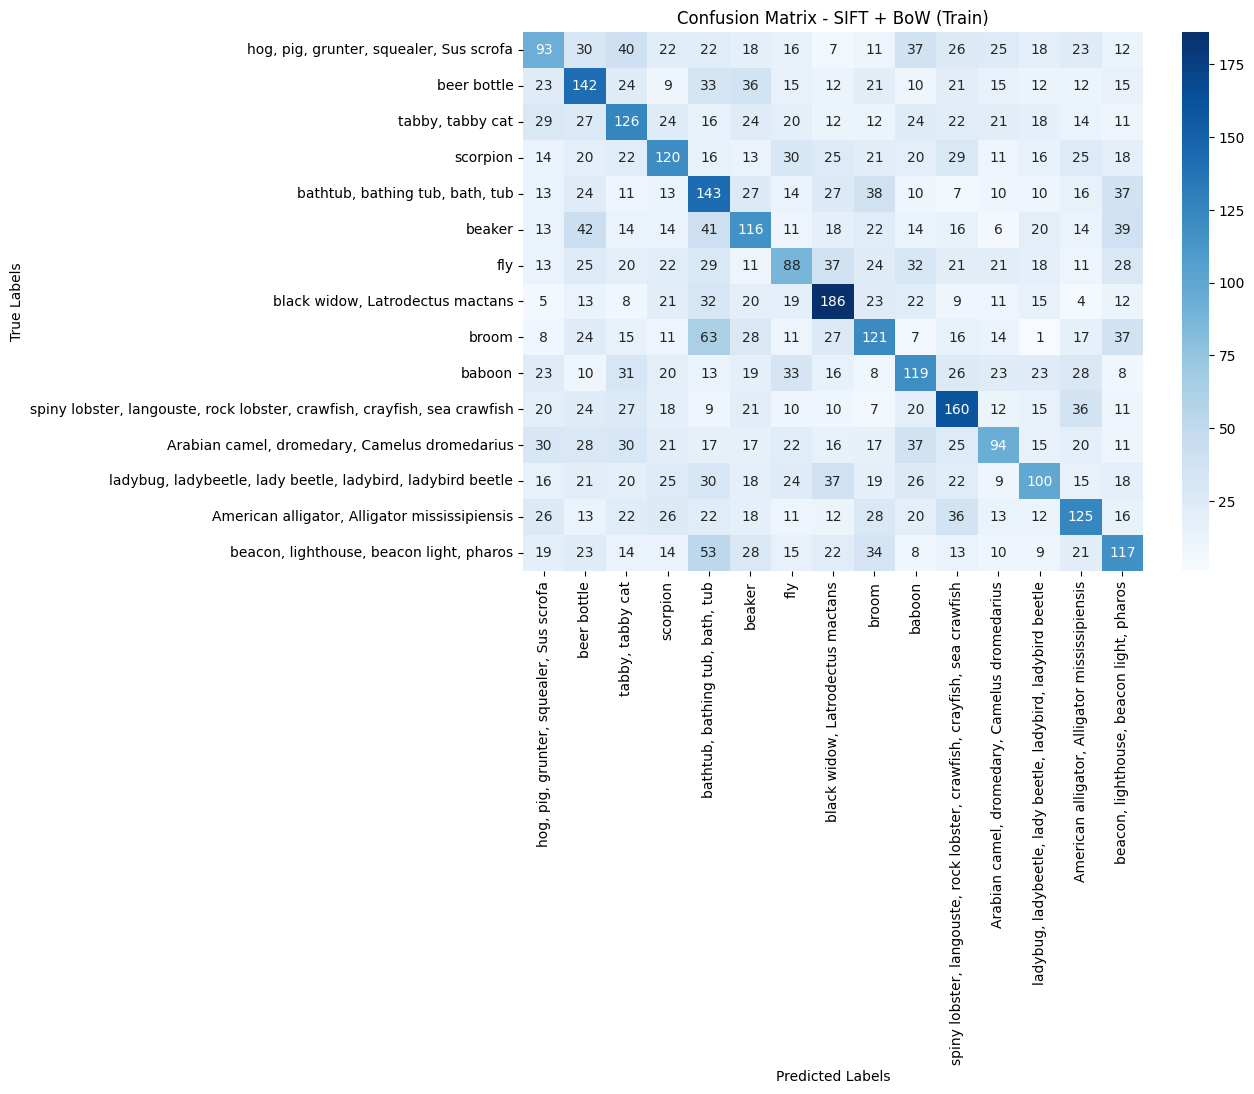

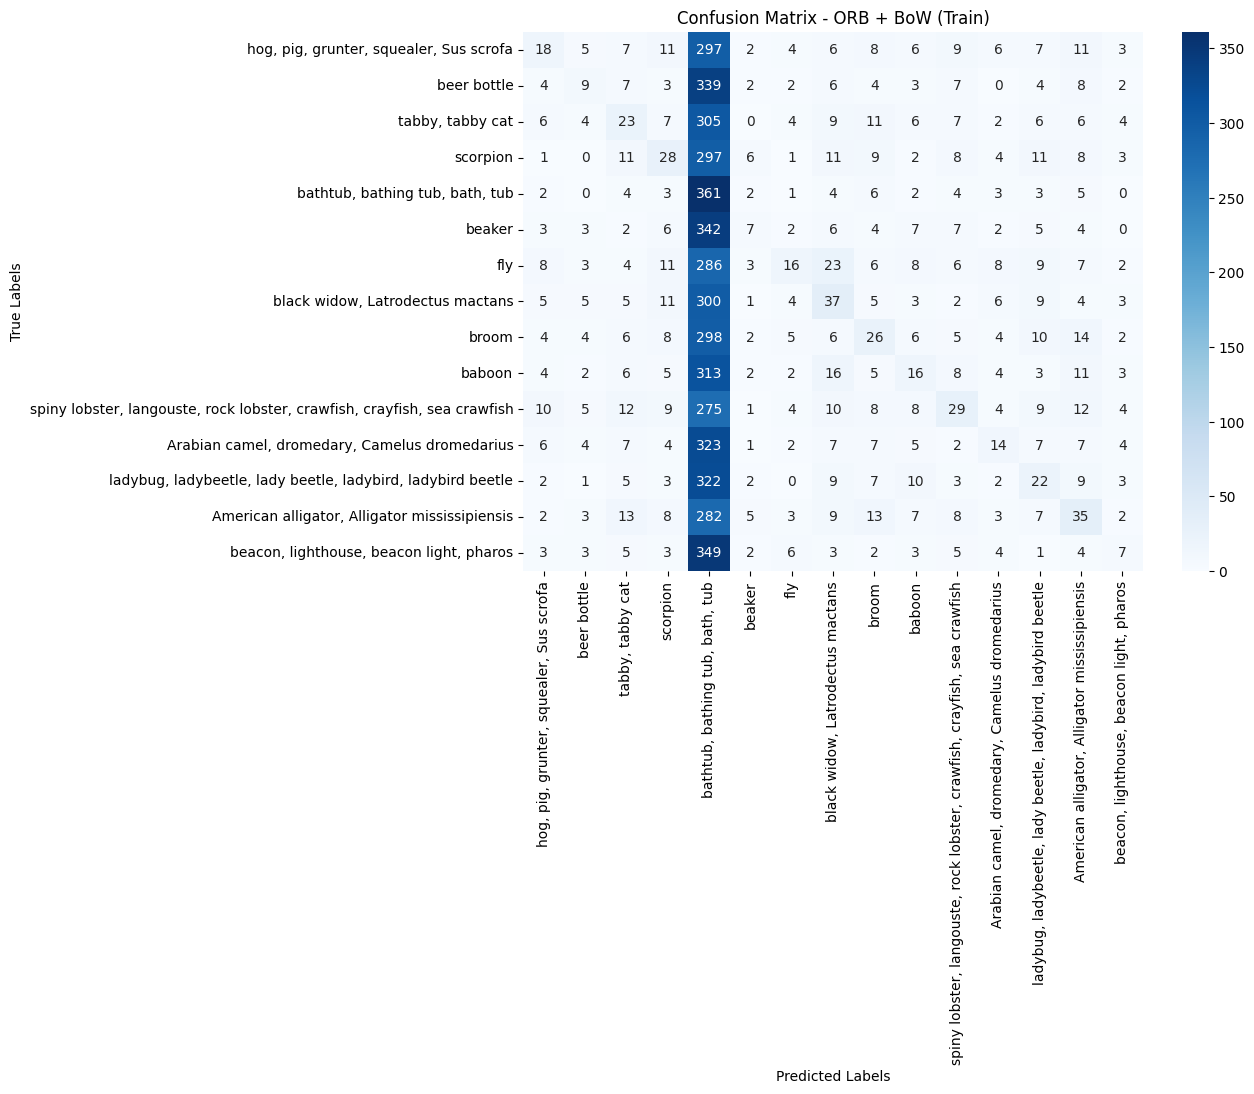

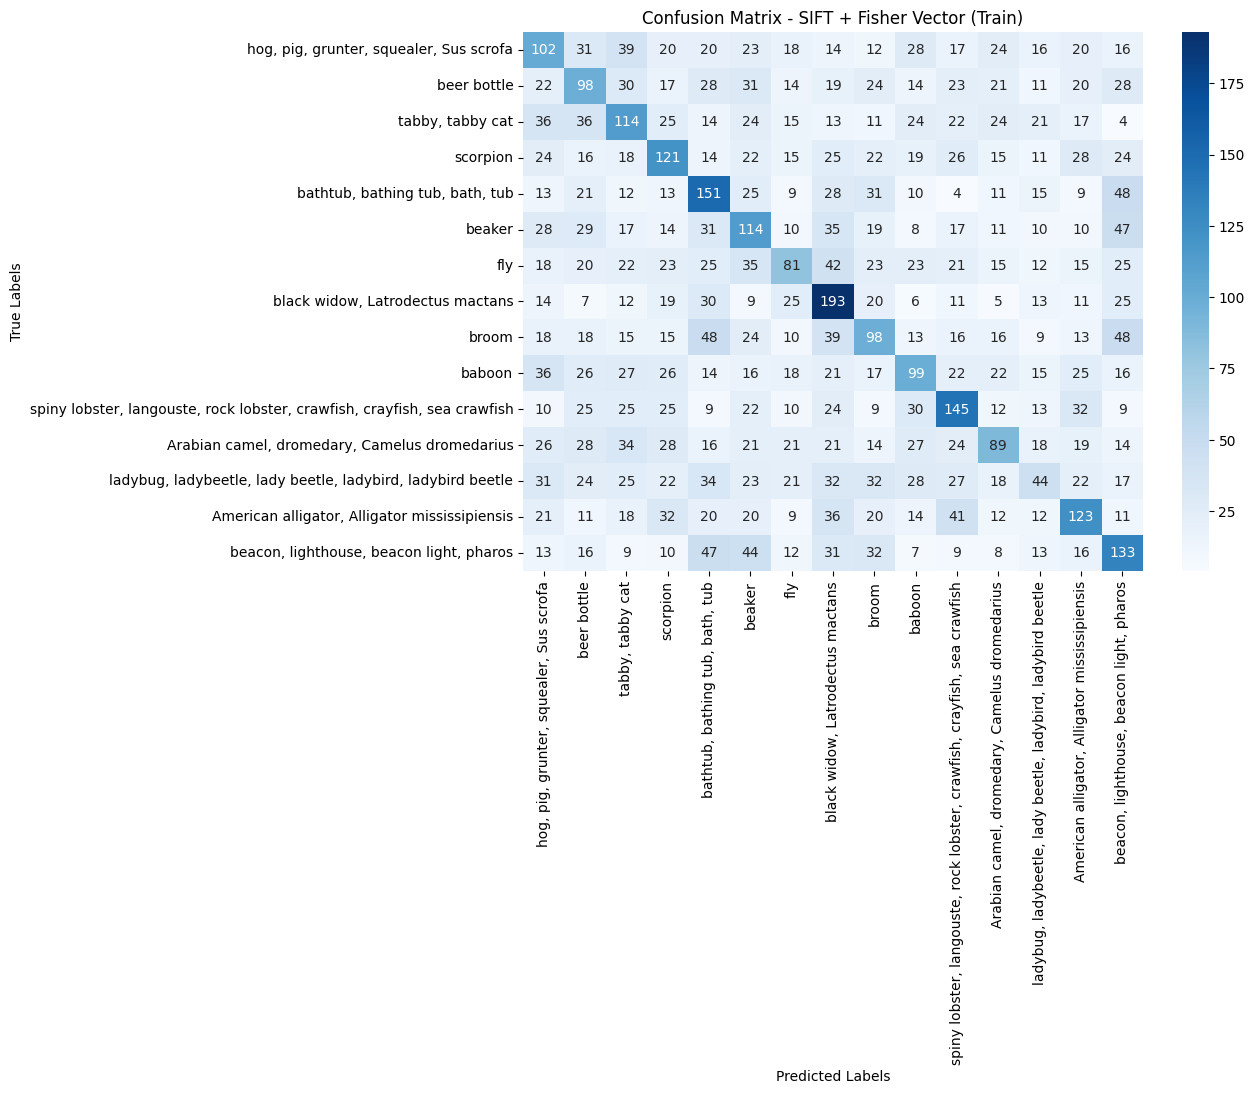

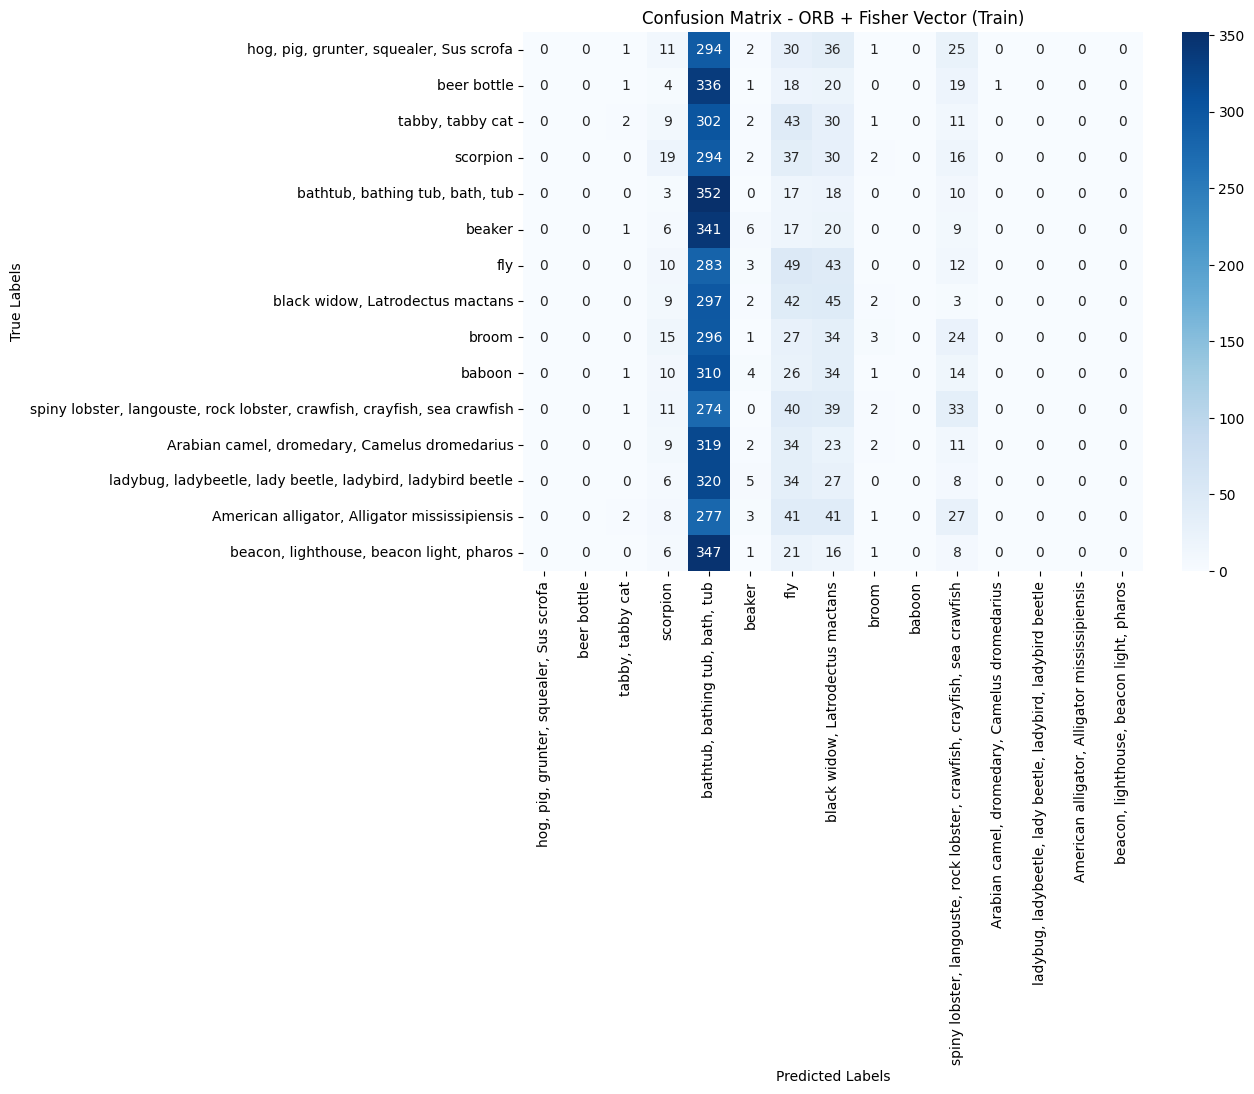

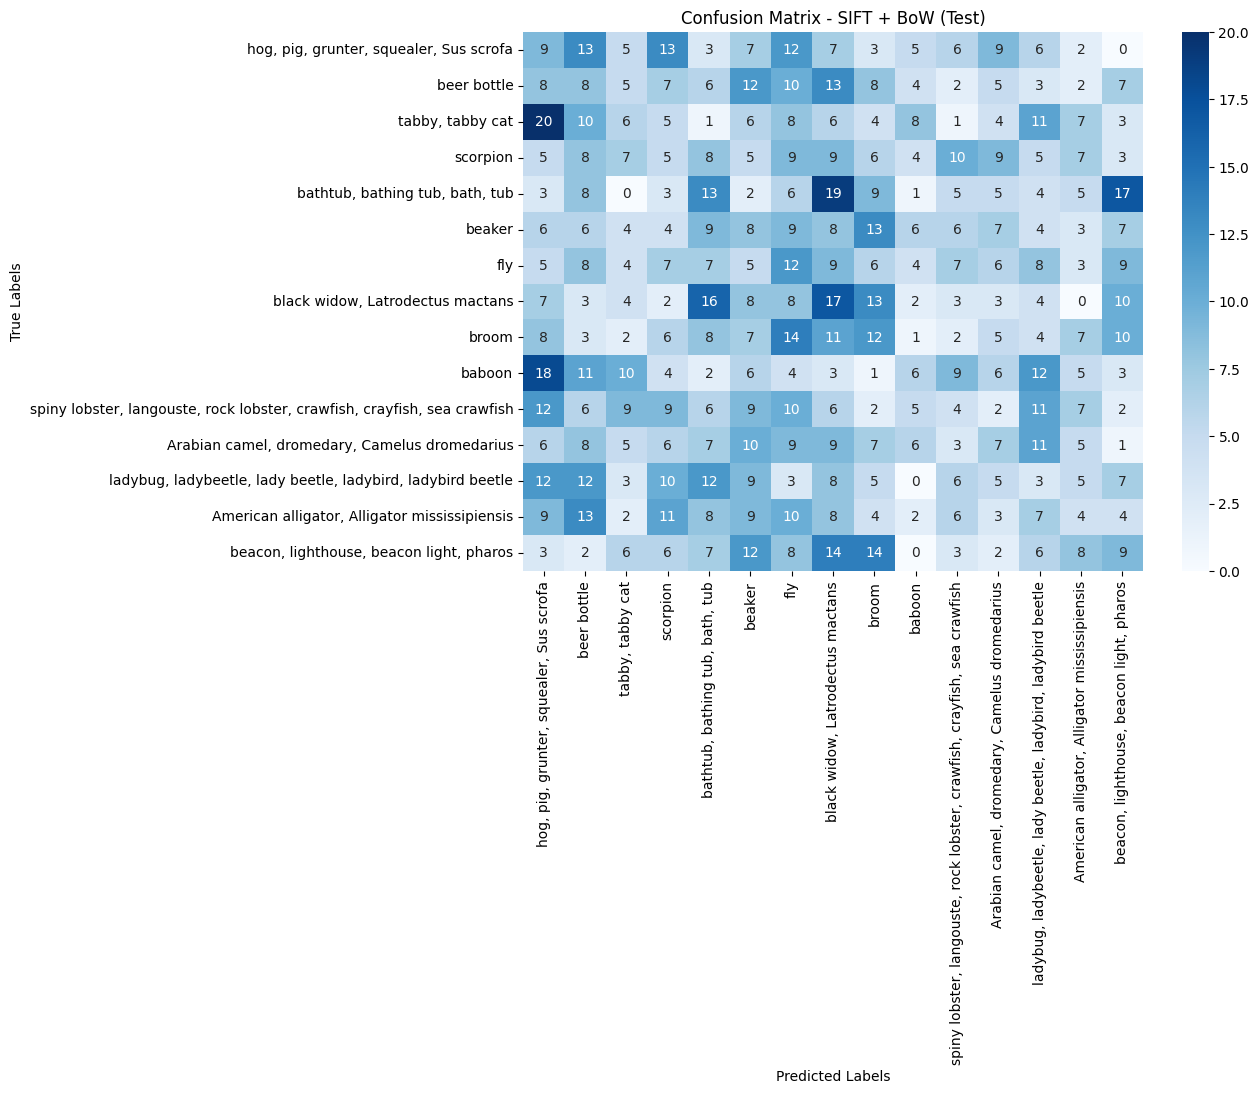

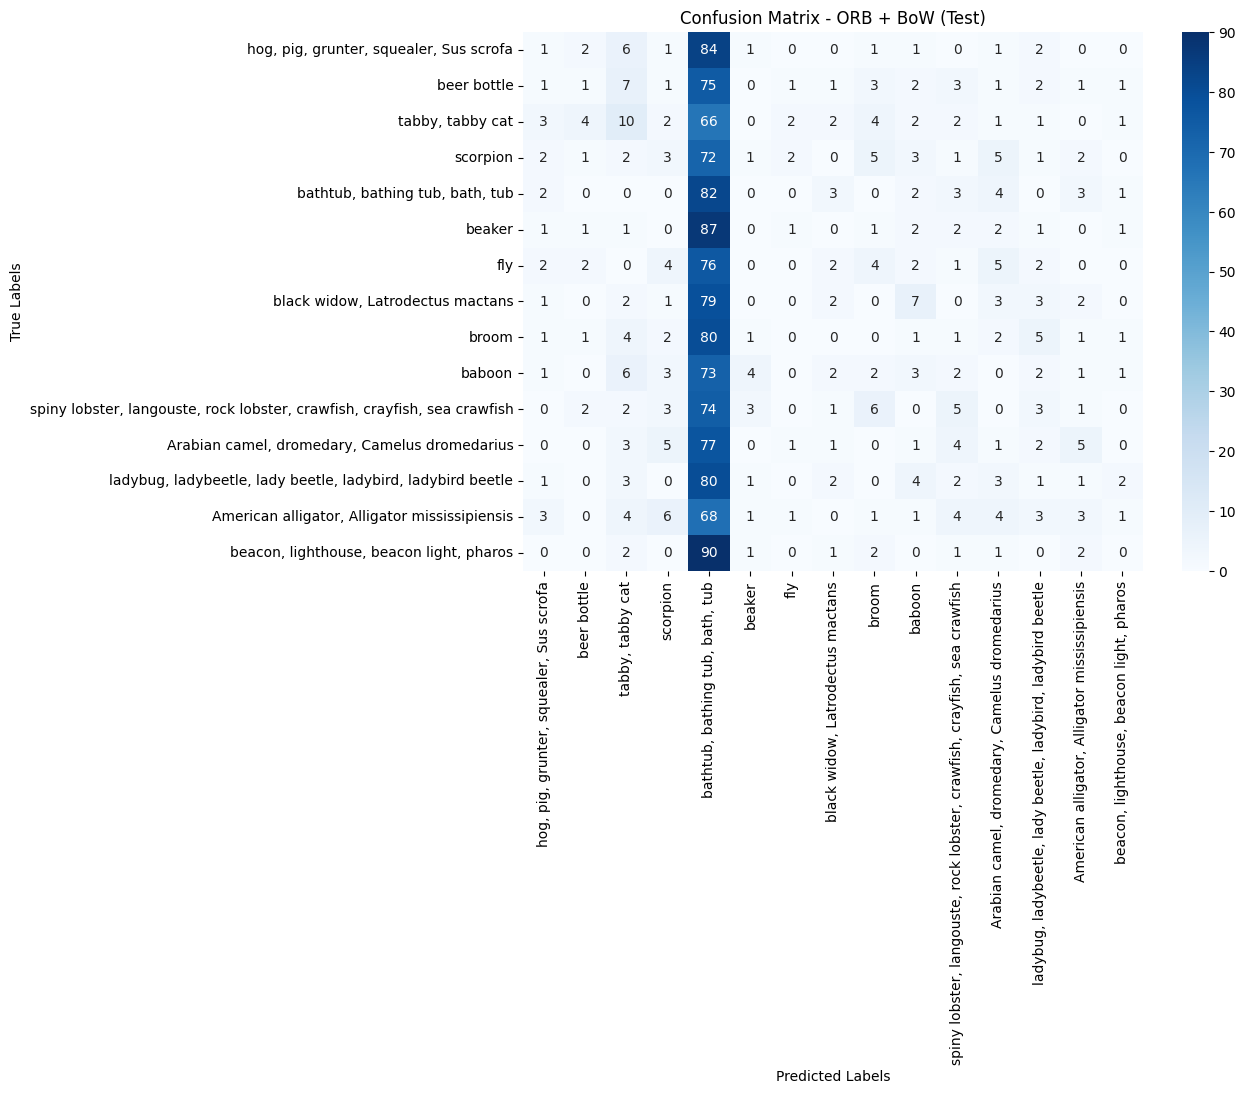

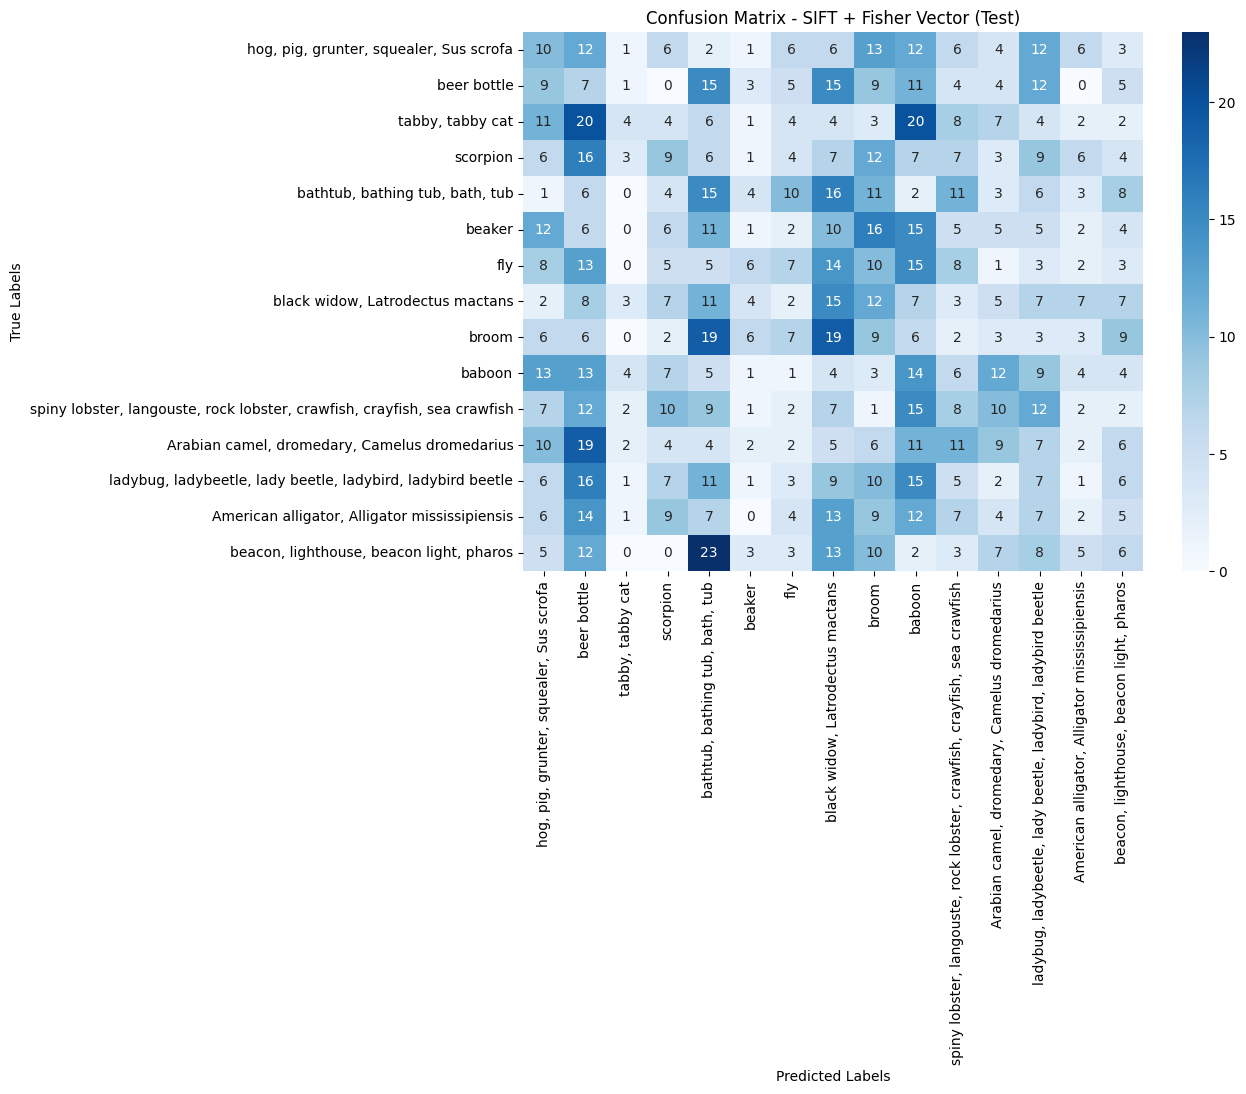

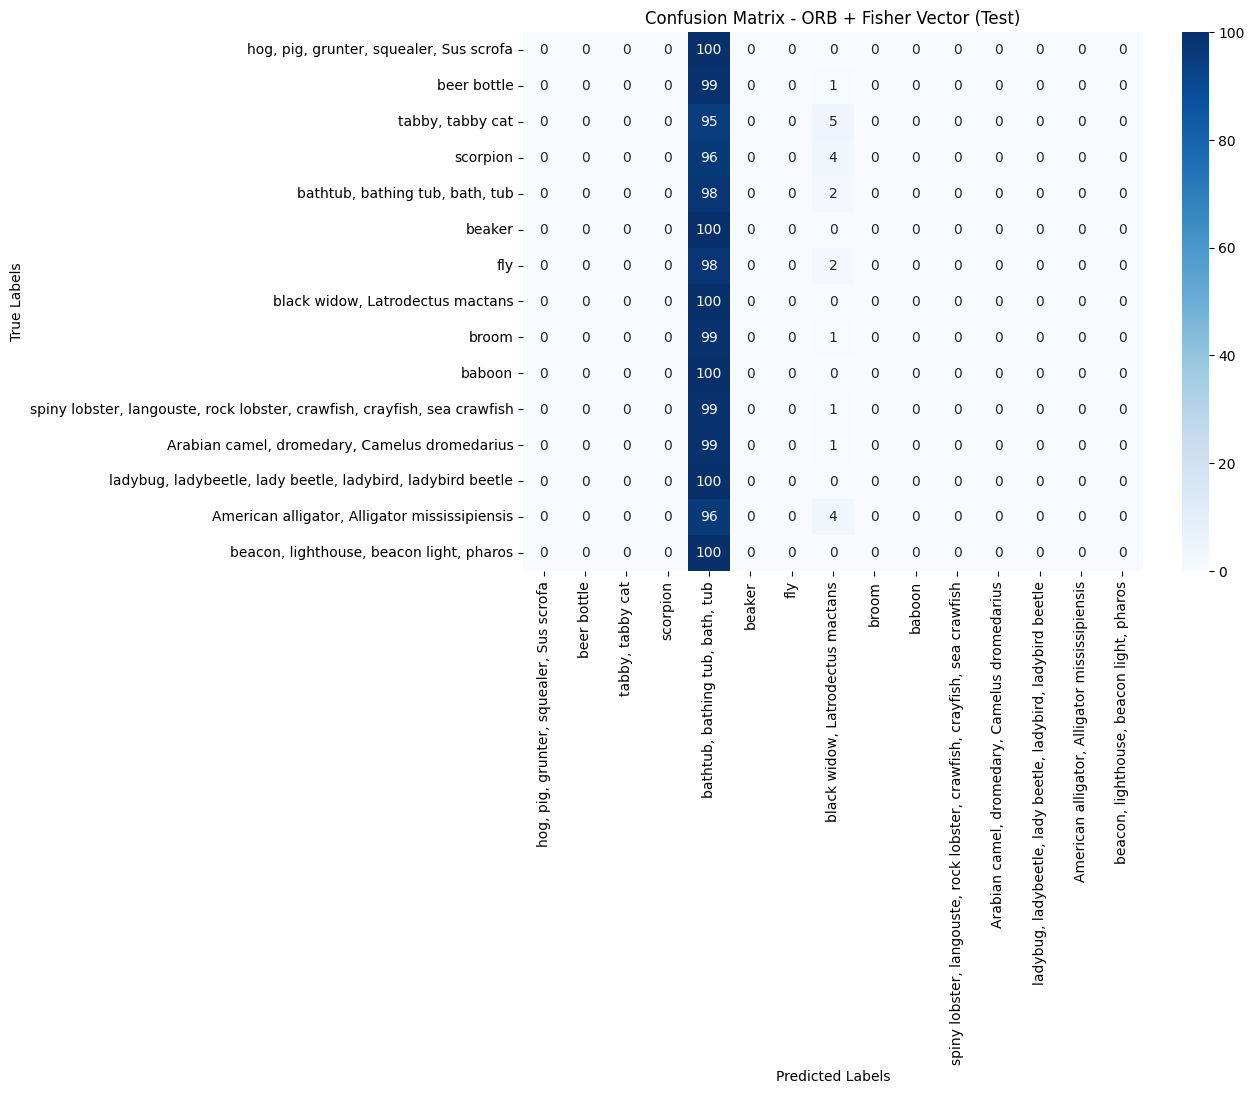

In [6]:


# Function to plot confusion matrices
def plot_confusion_matrix(true_labels, predictions, model_name, class_labels):
    conf_matrix = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Predictions for each model on the training set
y_pred_bow_sift_train = svm_bow_sift.predict(bow_features_sift)
y_pred_bow_orb_train = svm_bow_orb.predict(bow_features_orb)
y_pred_fisher_sift_train = svm_fisher_sift.predict(fisher_features_sift)
y_pred_fisher_orb_train = svm_fisher_orb.predict(fisher_features_orb)
# Build BoW and Fisher Vector models for the test set
bow_features_sift_test = build_bow_model(sift_test_features, num_clusters)
bow_features_orb_test = build_bow_model(orb_test_features, num_clusters)

fisher_features_sift_test = fisher_vector_encoding(sift_test_features, num_clusters)
fisher_features_orb_test = fisher_vector_encoding(orb_test_features, num_clusters)

# Predictions for each model on the test set
y_pred_bow_sift_test = svm_bow_sift.predict(bow_features_sift_test)
y_pred_bow_orb_test = svm_bow_orb.predict(bow_features_orb_test)
y_pred_fisher_sift_test = svm_fisher_sift.predict(fisher_features_sift_test)
y_pred_fisher_orb_test = svm_fisher_orb.predict(fisher_features_orb_test)

# Now you can proceed with the rest of the code to plot confusion matrices
# Class labels
target_names = [class_map[selected_classes[label]] for label in sorted(set(train_labels))]

# Plot Confusion Matrices for training set
plot_confusion_matrix(train_labels, y_pred_bow_sift_train, "SIFT + BoW (Train)", target_names)
plot_confusion_matrix(train_labels, y_pred_bow_orb_train, "ORB + BoW (Train)", target_names)
plot_confusion_matrix(train_labels, y_pred_fisher_sift_train, "SIFT + Fisher Vector (Train)", target_names)
plot_confusion_matrix(train_labels, y_pred_fisher_orb_train, "ORB + Fisher Vector (Train)", target_names)

# Plot Confusion Matrices for test set
plot_confusion_matrix(test_labels, y_pred_bow_sift_test, "SIFT + BoW (Test)", target_names)
plot_confusion_matrix(test_labels, y_pred_bow_orb_test, "ORB + BoW (Test)", target_names)
plot_confusion_matrix(test_labels, y_pred_fisher_sift_test, "SIFT + Fisher Vector (Test)", target_names)
plot_confusion_matrix(test_labels, y_pred_fisher_orb_test, "ORB + Fisher Vector (Test)", target_names)


In [ ]:
mapped_labels = [class_map[selected_classes[label]] for label in test_labels]

In [ ]:
target_names = [class_map[selected_classes[label]] for label in sorted(set(test_labels))]
target_names

['hog, pig, grunter, squealer, Sus scrofa',
 'beer bottle',
 'tabby, tabby cat',
 'scorpion',
 'bathtub, bathing tub, bath, tub',
 'beaker',
 'fly',
 'black widow, Latrodectus mactans',
 'broom',
 'baboon',
 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 'Arabian camel, dromedary, Camelus dromedarius',
 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle',
 'American alligator, Alligator mississipiensis',
 'beacon, lighthouse, beacon light, pharos']

##Phase 3

In [ ]:

# Function to preprocess images (with normalization)
def preprocess_images(img_paths, size=(64, 64)):
    images = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to read image at {img_path}. Skipping.")
            continue
        img = cv2.resize(img, size)
        img = img.astype('float32') / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)

# Load dataset (adjust paths accordingly)
train_images = preprocess_images(train_files)
test_images = preprocess_images(test_files)

# Check if images were loaded correctly
if len(train_images) == 0 or len(test_images) == 0:
    raise ValueError("No images were loaded. Check the file paths and ensure images exist.")

# Ensure labels are numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Convert labels to categorical encoding
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# Data Augmentation for better generalization
datagen = ImageDataGenerator(
    rotation_range=15,  # Rotate images by 15 degrees
    width_shift_range=0.1,  # Shift width by 10%
    height_shift_range=0.1,  # Shift height by 10%
    horizontal_flip=True  # Randomly flip images
)

# Build the improved MLP model
def build_optimized_mlp(input_shape, num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(1024, activation='relu'),  # More neurons
        layers.BatchNormalization(),
        layers.Dropout(0.4),  # Higher dropout to prevent overfitting
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile with AdamW optimizer and learning rate decay
    model.compile(
        optimizer=optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()
    return model

# Model Training Settings
input_shape = train_images.shape[1:]  # Input shape
num_classes = len(np.unique(train_labels))  # Number of classes

# Initialize model
mlp_model = build_optimized_mlp(input_shape, num_classes)

# Callbacks for better training
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the MLP model
print("Training the optimized MLP model...")
mlp_model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),  # Augmented training data
    epochs=50,  # More epochs for deeper model
    validation_data=(test_images, test_labels),
    callbacks=[early_stop, reduce_lr]
)

# Evaluate the model
print("Evaluating the optimized MLP model...")
loss, acc = mlp_model.evaluate(test_images, test_labels)
print(f"Optimized MLP Accuracy: {acc * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      12,583,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,251,087 (50.55 MB)

 Trainable params: 13,247,503 (50.54 MB)

 Non-trainable params: 3,584 (14.00 KB)

Training the optimized MLP model...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.1239 - loss: 3.2226 - val_accuracy: 0.1627 - val_loss: 4.5250 - learning_rate: 0.0010
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.1667 - loss: 2.7434 - val_accuracy: 0.1920 - val_loss: 2.7163 - learning_rate: 0.0010
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.1814 - loss: 2.6386 - val_accuracy: 0.2380 - val_loss: 2.3765 - learning_rate: 0.0010
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.1940 - loss: 2.5731 - val_accuracy: 0.2100 - val_loss: 2.4013 - learning_rate: 0.0010
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.2084 - loss: 2.5204 - val_accuracy: 0.2373 - val_loss: 2.3152 - learning_rate: 0.0010
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.2174 - loss: 2.4595 - val_accuracy: 0.2553 - val_loss: 2.2982 - learning_rate: 0.0010
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.2280 - loss: 2.4270 - val_accuracy: 0.

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

🔹 Model Accuracy: 35.33%

📊 Classification Report:
                                                                           precision    recall  f1-score   support

                                 hog, pig, grunter, squealer, Sus scrofa       0.19      0.21      0.20       100
                                                             beer bottle       0.33      0.29      0.31       100
                                                        tabby, tabby cat       0.27      0.27      0.27       100
                                                                scorpion       0.27      0.32      0.29       100
                                         bathtub, bathing tub, bath, tub       0.33      0.41      0.37       100
                                                                  beaker       0.48      0.27      0.35       100
                                                                     fly       0.54      0.35      0.42      

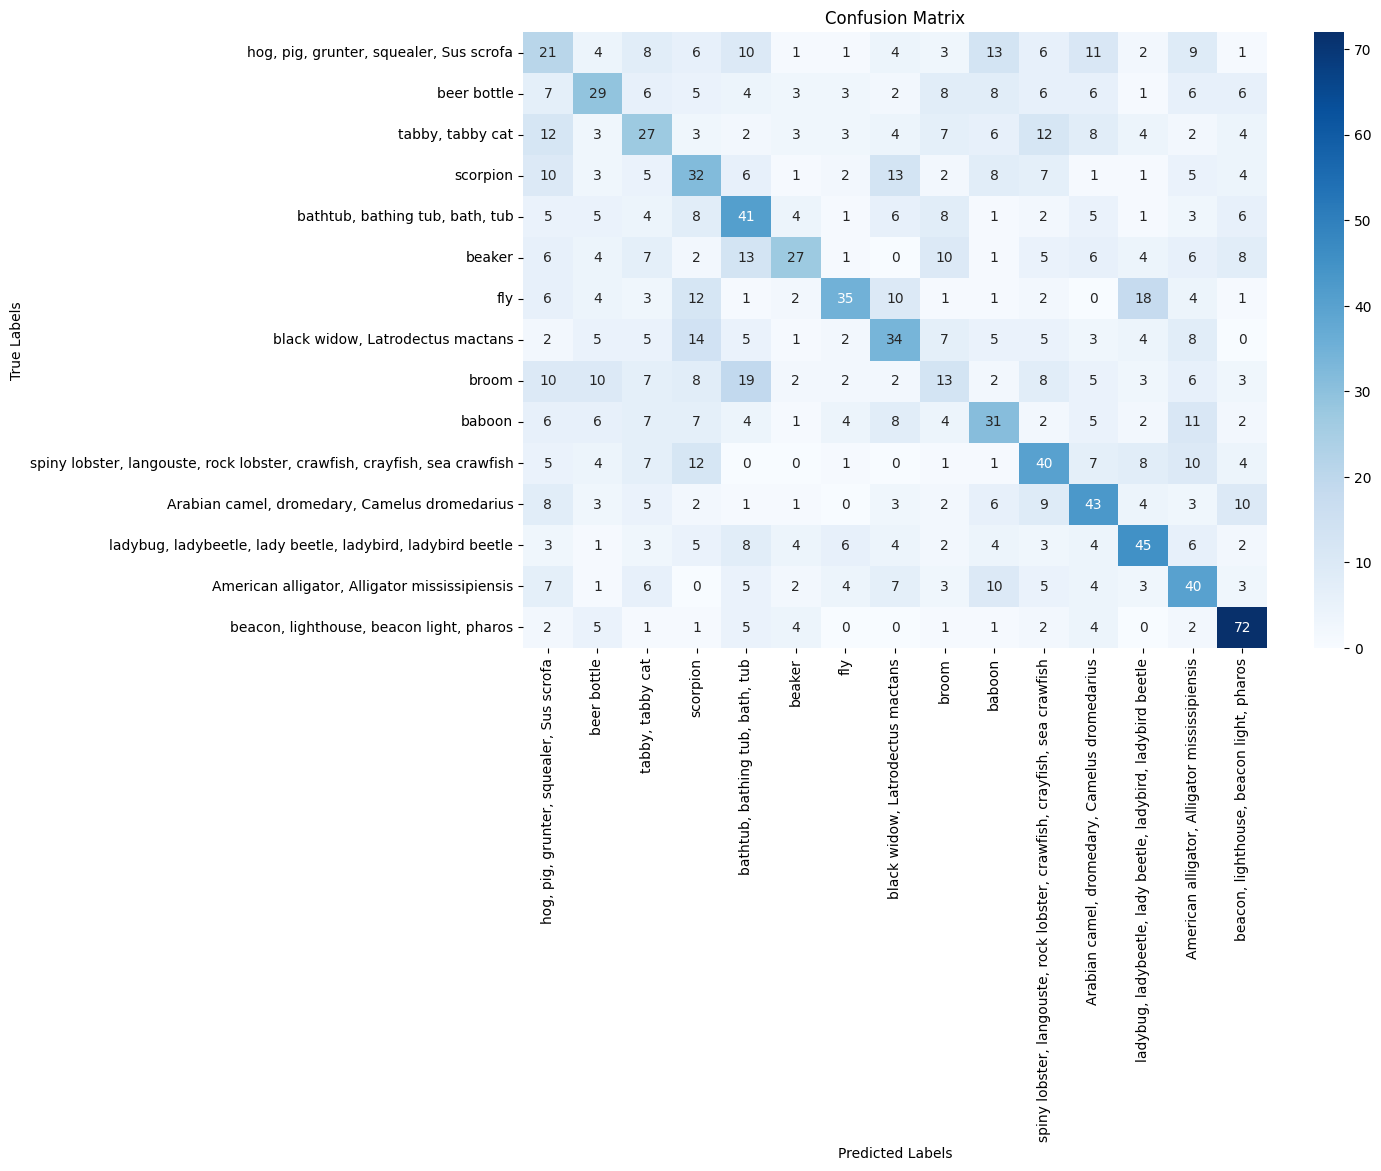

In [ ]:


# Get predictions
y_pred_probs = mlp_model.predict(test_images)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Compute accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f"\n🔹 Model Accuracy: {accuracy * 100:.2f}%")

# Generate classification report
class_report = classification_report(test_labels, y_pred, target_names=target_names)
print("\n📊 Classification Report:\n", class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.show()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.3506 - loss: 2.0128 - val_accuracy: 0.3527 - val_loss: 2.0599 - learning_rate: 2.5000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.3374 - loss: 2.0584 - val_accuracy: 0.3520 - val_loss: 2.0452 - learning_rate: 2.5000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.3471 - loss: 2.0281 - val_accuracy: 0.3527 - val_loss: 2.0441 - learning_rate: 2.5000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.3432 - loss: 2.0355 - val_accuracy: 0.3633 - val_loss: 2.0420 - learning_rate: 2.5000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.3433 - loss: 2.0304 - val_accuracy: 0.3333 - val_loss: 2.0796 - learning_rate: 2.5000e-04
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.3329 - loss: 2.0337 - val_accuracy: 0.3473 - val_loss: 2.0554 - learning_rate: 2.5000e-04
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.3445 - loss: 2.

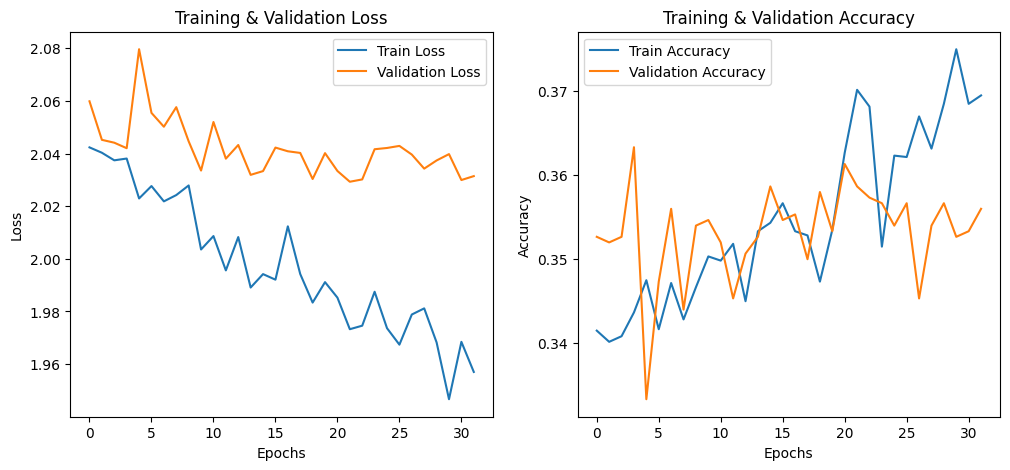

In [ ]:

# Train the model and store history
history = mlp_model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),
    epochs=50,
    validation_data=(test_images, test_labels),
    callbacks=[early_stop, reduce_lr]
)

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


In [ ]:
mlp_model.save('best_model_phase_3.h5')
print("MLP Model saved as best_model_phase_3.h5")

MLP Model saved as best_model_phase_3.h5


##Phase 4

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,196,431 (8.38 MB)

 Trainable params: 2,195,471 (8.38 MB)

 Non-trainable params: 960 (3.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.2043 - loss: 3.1527 - val_accuracy: 0.0667 - val_loss: 3.3166 - learning_rate: 0.0010
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.3033 - loss: 2.3449 - val_accuracy: 0.0773 - val_loss: 3.9415 - learning_rate: 0.0010
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.3619 - loss: 2.0923 - val_accuracy: 0.1513 - val_loss: 2.8461 - learning_rate: 0.0010
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.4122 - loss: 1.9097 - val_accuracy: 0.2893 - val_loss: 2.2331 - learning_rate: 0.0010
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.4415 - loss: 1.7597 - val_accuracy: 0.3627 - val_loss: 1.9711 - learning_rate: 0.0010
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.4704 - loss: 1.6811 - val_accuracy: 0.4033 - val_loss: 1.9158 - learning_rate: 0.0010
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.5141 - loss: 1.5511 - val_

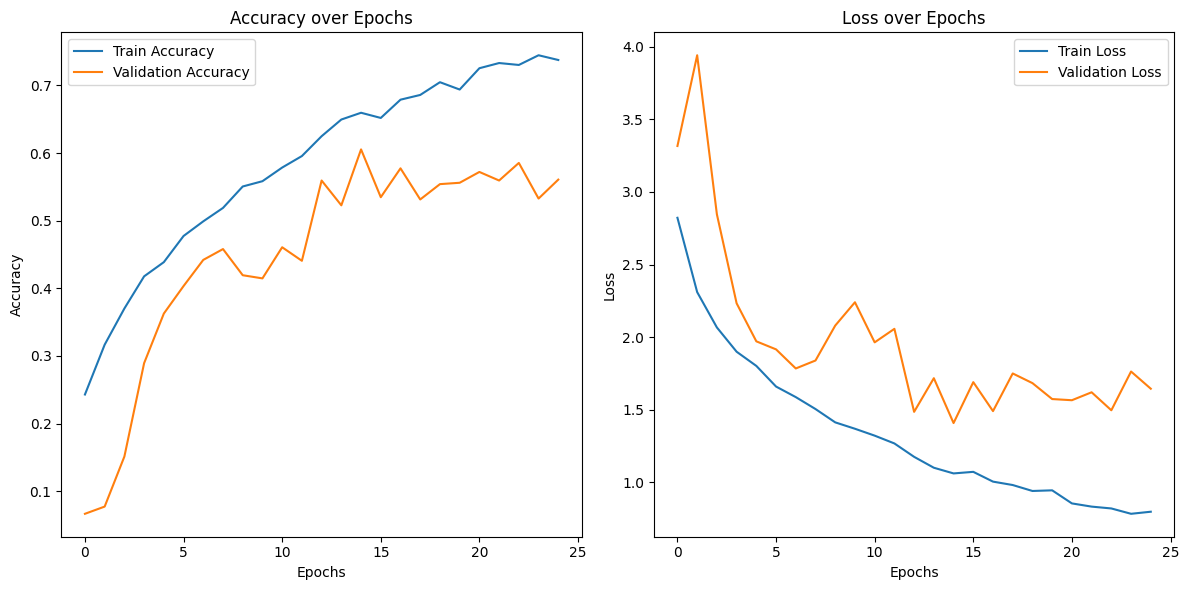

In [ ]:


# Preprocess images function
def preprocess_images(img_paths, size=(64, 64)):
    images = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to read image at {img_path}. Skipping.")
            continue
        img = cv2.resize(img, size)
        img = img.astype('float32') / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)

# Load dataset
train_images = preprocess_images(train_files)
test_images = preprocess_images(test_files)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Label encoding
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# CNN Model Architecture
def build_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()
    return model

# Train and evaluate CNN
cnn_model = build_cnn_model(input_shape=train_images.shape[1:], num_classes=len(np.unique(train_labels)))

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history = cnn_model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),
    epochs=50,
    validation_data=(test_images, test_labels),
    callbacks=[early_stop, reduce_lr]
)

# Evaluate the CNN model
loss, acc = cnn_model.evaluate(test_images, test_labels)
print(f"Optimized CNN Accuracy: {acc * 100:.2f}%")

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Final Accuracy: 60.53%
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
                                                                           precision    recall  f1-score   support

                                 hog, pig, grunter, squealer, Sus scrofa       0.68      0.34      0.45       100
                                                             beer bottle       0.63      0.77      0.69       100
                                                        tabby, tabby cat       0.76      0.42      0.54       100
                                                                scorpion       0.47      0.42      0.44       100
                                         bathtub, bathing tub, bath, tub       0.64      0.55      0.59       100
                                                                  beaker       0.72      0.61      0.66       100
                                                                     fly       0.63      0.68      0.65       100


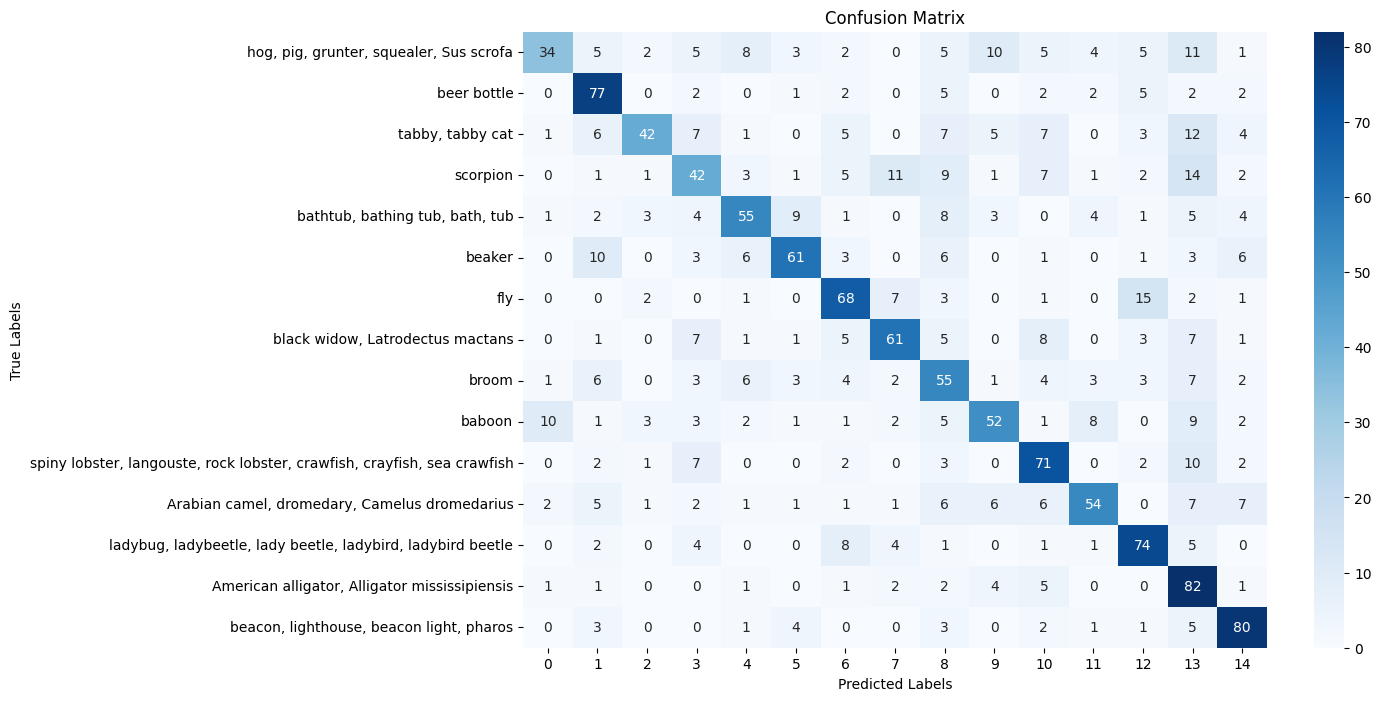

Best model saved as 'cnn_model_phase4.h5'


In [ ]:
# Final Accuracy
accuracy = np.sum(y_pred == test_labels) / len(test_labels)
print(f"Final Accuracy: {accuracy * 100:.2f}%")

# Classification Report
y_pred_probs = cnn_model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print classification report with class names
class_report = classification_report(test_labels, y_pred, target_names=target_names)
print("\nClassification Report:\n", class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_.astype(str), yticklabels=
            target_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
cnn_model.save('cnn_model_phase4.h5')  # Save only the best model
print(f"Best model saved as 'cnn_model_phase4.h5'")





Additional hyperparameter tuning for phase 4

Training with configuration 1: {'dropout_rate': 0.5, 'learning_rate': 0.001, 'filters': (32, 64, 128)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,196,431 (8.38 MB)

 Trainable params: 2,195,471 (8.38 MB)

 Non-trainable params: 960 (3.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 0.2024 - loss: 3.0910 - val_accuracy: 0.0667 - val_loss: 4.9075 - learning_rate: 0.0010
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.3300 - loss: 2.2059 - val_accuracy: 0.1033 - val_loss: 3.4839 - learning_rate: 0.0010
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.3731 - loss: 2.0604 - val_accuracy: 0.1667 - val_loss: 3.0025 - learning_rate: 0.0010
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.4311 - loss: 1.8880 - val_accuracy: 0.1147 - val_loss: 3.0299 - learning_rate: 0.0010
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.4714 - loss: 1.6912 - val_accuracy: 0.3280 - val_loss: 2.0933 - learning_rate: 0.0010
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.4682 - loss: 1.6734 - val_accuracy: 0.4387 - val_loss: 1.8357 - learning_rate: 0.0010
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.4933 - loss: 1.5869 - val_

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,130,127 (4.31 MB)

 Trainable params: 1,129,231 (4.31 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.1634 - loss: 3.2916 - val_accuracy: 0.0667 - val_loss: 4.6408 - learning_rate: 0.0010
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.3069 - loss: 2.3540 - val_accuracy: 0.0820 - val_loss: 3.8896 - learning_rate: 0.0010
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.3519 - loss: 2.1037 - val_accuracy: 0.1180 - val_loss: 3.0622 - learning_rate: 0.0010
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.4051 - loss: 1.9207 - val_accuracy: 0.2293 - val_loss: 2.4508 - learning_rate: 0.0010
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.4261 - loss: 1.8212 - val_accuracy: 0.4107 - val_loss: 1.8437 - learning_rate: 0.0010
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.4549 - loss: 1.7115 - val_accuracy: 0.4453 - val_loss: 1.7670 - learning_rate: 0.0010
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.4738 - loss: 1.6468 - val_

Configuration 2 - Accuracy: 59.60%
Best model saved as 'best_model_phase4.h5'


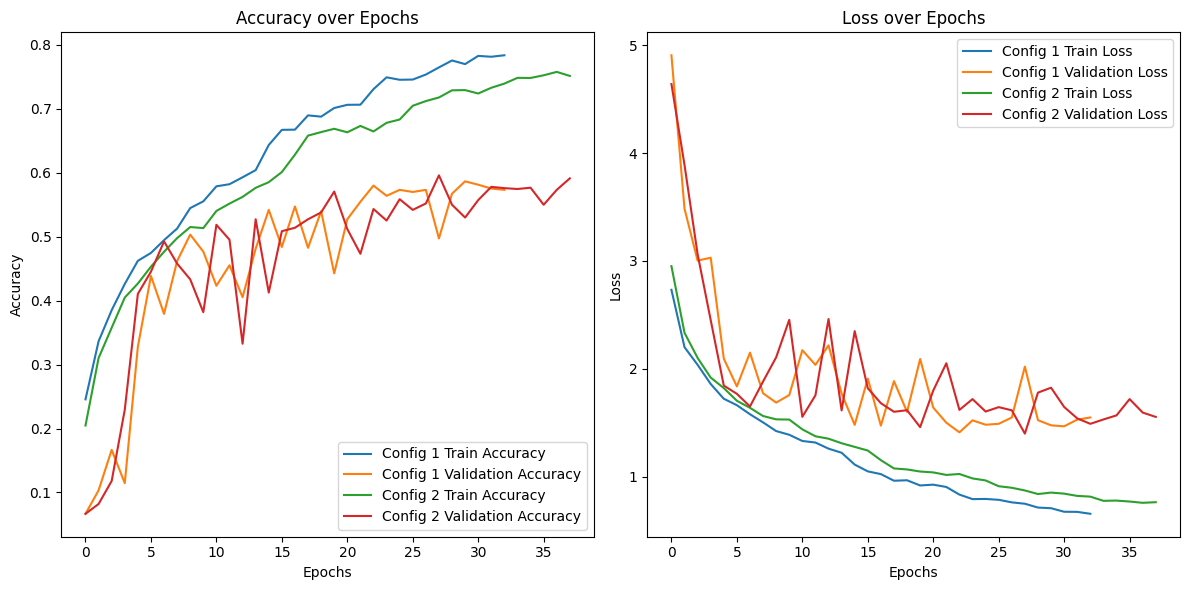

In [ ]:
# Preprocess images function
def preprocess_images(img_paths, size=(64, 64)):
    images = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to read image at {img_path}. Skipping.")
            continue
        img = cv2.resize(img, size)
        img = img.astype('float32') / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)

# Load dataset
train_images = preprocess_images(train_files)
test_images = preprocess_images(test_files)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Label encoding
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# CNN Model Architecture (Keras)
def build_cnn_model(input_shape, num_classes, dropout_rate=0.5, learning_rate=0.001, filters=(32, 64, 128)):
    model = models.Sequential([
        layers.Conv2D(filters[0], (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),

        layers.Conv2D(filters[1], (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),

        layers.Conv2D(filters[2], (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()
    return model

# Hyperparameter configurations (original + one filter size)
hyperparameters = [
    {'dropout_rate': 0.5, 'learning_rate': 0.001, 'filters': (32, 64, 128)},  # Original filters
    {'dropout_rate': 0.5, 'learning_rate': 0.001, 'filters': (64, 64, 64)}  # One filter size (all the same)
]

best_model = None
best_acc = 0
history_dict = {}

# Train and evaluate CNN with different hyperparameters
for idx, params in enumerate(hyperparameters):
    print(f"Training with configuration {idx + 1}: {params}")

    cnn_model = build_cnn_model(
        input_shape=train_images.shape[1:],
        num_classes=len(np.unique(train_labels)),
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        filters=params['filters']
    )

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

    history = cnn_model.fit(
        datagen.flow(train_images, train_labels, batch_size=64),
        epochs=50,
        validation_data=(test_images, test_labels),
        callbacks=[early_stop, reduce_lr]
    )

    # Evaluate the CNN model
    loss, acc = cnn_model.evaluate(test_images, test_labels)
    print(f"Configuration {idx + 1} - Accuracy: {acc * 100:.2f}%")

    history_dict[idx] = history.history

    # Update the best model
    if acc > best_acc:
        best_acc = acc
        best_model = cnn_model
        best_params = params
        best_history = history_dict[idx]

# Save the best model
if best_model:
    best_model.save('best_model_phase4.h5')  # Save only the best model
    print(f"Best model saved as 'best_model_phase4.h5'")

# Plot training and validation accuracy/loss for all configurations
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
for idx in range(len(hyperparameters)):
    plt.plot(history_dict[idx]['accuracy'], label=f'Config {idx + 1} Train Accuracy')
    plt.plot(history_dict[idx]['val_accuracy'], label=f'Config {idx + 1} Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
for idx in range(len(hyperparameters)):
    plt.plot(history_dict[idx]['loss'], label=f'Config {idx + 1} Train Loss')
    plt.plot(history_dict[idx]['val_loss'], label=f'Config {idx + 1} Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
